# Making predictions over amazon recommendation dataset

## Predictions
The purpose of this analysis is to make up a prediction model where we will be able to predict whether a recommendation is positive or negative. In this analysis, the prediction model is not focusing on the Score, but only the positive/negative sentiment of the recommendation. 

To do so, a Term-doc incidence matrix using term frequency and inverse document frequency ponderation is built. When the data is ready, it will be loaded into predicitve algorithms. In the end, the algorithms is hoped to find a "best" model for predicting the recommendation's sentiment.

## Loading the data
As the interest of the project is only to get the global sentiment of the recommendations (positive or negative), all scores equal to 3 is purposefully ignored. If the score id above 3, then the recommendation wil be set to "postive". Otherwise, it will be set to "negative". 

The data will be split into an training set and a test set with a test set ratio of 0.2

In [167]:
import pandas as pd
import numpy as np
import pickle

In [2]:
df = pd.read_csv('Reviews.csv')

In [3]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [4]:
df.shape # data shape

(568454, 10)

In [5]:
df.nunique() # check num of unique items per column

Id                        568454
ProductId                  74258
UserId                    256059
ProfileName               218416
HelpfulnessNumerator         231
HelpfulnessDenominator       234
Score                          5
Time                        3168
Summary                   295742
Text                      393579
dtype: int64

In [6]:
df.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

In [7]:
# rename columns HelpfulnessNumerator and HelpfulnessDenominator
df.columns = ["Id", "ProductId", "UserId", "ProfileName", "VotesHelpful",
              "VotesTotal", "Score", "Time", "Summary", "Text"]

Add the **Sentiment** column that turns the numeric score into either *positive* or *negative*.

Similarly, the **Usefulness** column turns the number of votes into a boolean.

In [8]:
df["Sentiment"] = df["Score"].apply(lambda score: "positive" if score > 3 else "negative")
df.head(5)

,Id,ProductId,UserId,ProfileName,VotesHelpful,VotesTotal,Score,Time,Summary,Text,Sentiment
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,positive
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,negative
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,positive
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,negative
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,positive


In [9]:
# check some statistics
print(df['Sentiment'].value_counts())

positive    443777
negative    124677
Name: Sentiment, dtype: int64


Select subcolumns

In [10]:
df = df[["Score", "Sentiment", "Summary", "Text"]]

Let's have a look at some 5s:

In [11]:
df[df.Score == 5].head(10)

,Score,Sentiment,Summary,Text
0,5,positive,Good Quality Dog Food,I have bought several of the Vitality canned d...
4,5,positive,Great taffy,Great taffy at a great price. There was a wid...
6,5,positive,Great! Just as good as the expensive brands!,This saltwater taffy had great flavors and was...
7,5,positive,"Wonderful, tasty taffy",This taffy is so good. It is very soft and ch...
8,5,positive,Yay Barley,Right now I'm mostly just sprouting this so my...
9,5,positive,Healthy Dog Food,This is a very healthy dog food. Good for thei...
10,5,positive,The Best Hot Sauce in the World,I don't know if it's the cactus or the tequila...
11,5,positive,"My cats LOVE this ""diet"" food better than thei...",One of my boys needed to lose some weight and ...
14,5,positive,Strawberry Twizzlers - Yummy,The Strawberry Twizzlers are my guilty pleasur...
15,5,positive,"Lots of twizzlers, just what you expect.",My daughter loves twizzlers and this shipment ...


And some 1s as well:

In [12]:
df[df.Score == 1].head(10)

,Score,Sentiment,Summary,Text
1,1,negative,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
12,1,negative,My Cats Are Not Fans of the New Food,My cats have been happily eating Felidae Plati...
26,1,negative,Nasty No flavor,"The candy is just red , No flavor . Just plan..."
50,1,negative,Don't like it,"This oatmeal is not good. Its mushy, soft, I d..."
62,1,negative,stale product.,Arrived in 6 days and were so stale i could no...
73,1,negative,Warning! WARNING! -ALCOHOL SUGARS!,Buyer Beware Please! This sweetener is not for...
75,1,negative,No Tea Flavor,No tea flavor at all. Just whole brunch of art...
99,1,negative,Bad,I fed this to my Golden Retriever and he hated...
153,1,negative,Rip off Price,These singles sell for $2.50 - $3.36 at the st...
164,1,negative,Tasteless but low calorie,Seriously this product was as tasteless as the...


## Cleaning the data

To format our data and build the Term-doc incidence matrix, many operations will be performed on the data :

- Stop words removal
- Stemming
- Punctuations
- Lowering

### Stopwords
* A stop word is a commonly used word (such as “the”, “a”, “an”, “in”) that a search engine has been programmed to ignore, both when indexing entries for searching and when retrieving them as the result of a search query.

![alt text](https://www.geeksforgeeks.org/wp-content/uploads/Stop-word-removal-using-NLTK.png)

In [13]:
import nltk
# nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')
print(stop)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [14]:
'not' in stop

True

## So stopwords removal is not appropriate for this modeling. 

### stemming

In [15]:
from nltk.stem import SnowballStemmer # Stemmers remove morphological affixes from words, leaving only the word stem.
snow = SnowballStemmer('english') 
print(snow.stem('tasty'))
print(snow.stem('joined'))
print(snow.stem('apples'))

tasti
join
appl


### Punctuations Removal

In [16]:
import re
# cleaning punctuations from the sentence
sentence = "I'd like to have some coffee today!"
sentence = re.sub(r'[\'|"|#]', r'', sentence) # remove these punctuation
sentence = re.sub(r'[?|!|.|,|)|(|\|/]',r' ',sentence) # replace these punctuation with space
sentence

'Id like to have some coffee today '

### combine

In [17]:
def cleanup(sentence):
    sentence = str(sentence)
    sentence = sentence.lower() # lower case
    sentence = re.sub(r'[?|!|.|,|)|(|\|/]',r' ',sentence) # replace these punctuation with space
    tokens = sentence.split()
    out = []
    for t in tokens:
        out.append(snow.stem(t))
    out = " ".join(out)
    out = re.sub(r'[\'|"|#]', r'', out) # remove these punctuation
    return out    

In [18]:
# note that in this example, we do not use stopwords removal. 
# b/c stopwords like 'not', "hadn't" for example, have strong negative signal. 

In [19]:
print(cleanup("how are you today?"))
print(cleanup("Not as Advertised"))
print(cleanup(6))

how are you today
not as advertis
6


In [20]:
df["Summary_Clean"] = df["Summary"].apply(cleanup)

### get fancy with WordClouds!

In [21]:
# !pip install wordcloud
# !pip install matplotlib

In [22]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
from wordcloud import WordCloud, STOPWORDS

#mpl.rcParams['figure.figsize']=(8.0,6.0)    #(6.0,4.0)
mpl.rcParams['font.size']=12                #10 
mpl.rcParams['savefig.dpi']=100             #72 
mpl.rcParams['figure.subplot.bottom']=.1 

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=None,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))
    
    fig = plt.figure(1, figsize=(8, 8))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

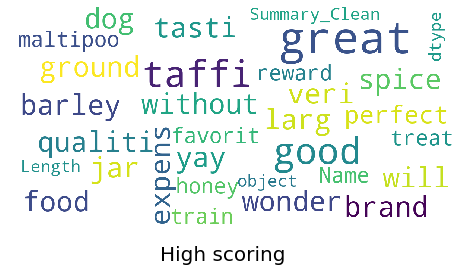

In [23]:
show_wordcloud(df.Summary_Clean.loc[df.Score == 5], title = "High scoring")

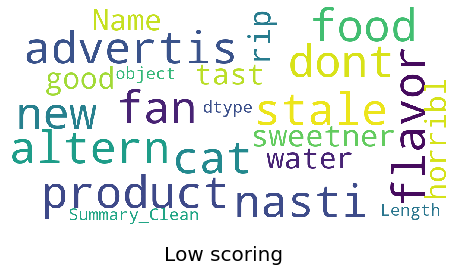

In [24]:
show_wordcloud(df.Summary_Clean.loc[df.Score == 1], title = "Low scoring")

### train test split

In [25]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.2, random_state = 1)
print("%d items in training data, %d in test data" % (len(train), len(test)))

454763 items in training data, 113691 in test data


In [26]:
train = train.reset_index(drop=True)
train.head()

,Score,Sentiment,Summary,Text,Summary_Clean
0,5,positive,The best espresso i've ever had,"I've tried many types, but out of all of them,...",the best espresso iv ever had
1,3,negative,"False advertising, but tasty",The only thing chipotle about this sauce is in...,fals advertis but tasti
2,1,negative,Deadly treat,I bought these at a local store. I broke up th...,dead treat
3,3,negative,Too Strong,I ordered light roast coffee and was sent one ...,too strong
4,4,positive,Very Good Tea,This tea is very good. A cup in the morning an...,veri good tea


In [27]:
test = test.reset_index(drop=True)
test.head()

,Score,Sentiment,Summary,Text,Summary_Clean
0,5,positive,Cherry Pie Larabar,I love the Cherry Pie Lara bar. Best and tast...,cherri pie larabar
1,5,positive,Melitta Coffee,Melitta Cafe COllection Blanc et Noir coffee h...,melitta coffe
2,5,positive,great treat,my girls absolutely loved this tuna. they were...,great treat
3,5,positive,Daily Calming,The vendor is fast and dependable. The tea is ...,daili calm
4,5,positive,Best Canned Artichokes Out There!,UPDATE - 8/9/2010<br />A lot can happen in jus...,best can artichok out there


# Ways to convert text to vector
## *1) Uni-gram BOW*

In [28]:
from sklearn.feature_extraction.text import CountVectorizer

In [29]:
train['Summary_Clean'].values

array(['the best espresso iv ever had', 'fals advertis but tasti',
       'dead treat', ..., 'best waffel mix ever', 'tri it youll love it',
       'not worth the money'], dtype=object)

In [30]:
uni_gram = CountVectorizer(min_df = 5, binary = True) # only use keyword which shows up more than 5 times. 
uni_gram_vectors_train = uni_gram.fit_transform(train['Summary_Clean'].values)
uni_gram_vectors_test = uni_gram.transform(test['Summary_Clean'].values)

In [31]:
uni_gram_vectors_train.shape

(454763, 8208)

In [32]:
uni_gram_vectors_train[0]

<1x8208 sparse matrix of type '<class 'numpy.int64'>'
	with 6 stored elements in Compressed Sparse Row format>

In [33]:
type(uni_gram_vectors_train)

scipy.sparse.csr.csr_matrix

## *2) Bi-gram BOW*

In [34]:
bi_gram = CountVectorizer(ngram_range=(1,2), min_df = 5, binary = True) # 1 means the minimum is unigram, 2 means max is bigrams, 
bi_gram_vectors_train = bi_gram.fit_transform(train['Summary_Clean'].values)
bi_gram_vectors_test = bi_gram.transform(test['Summary_Clean'].values)


In [35]:
bi_gram_vectors_train.shape

(454763, 46995)

In [36]:
features = bi_gram.get_feature_names()
features[-20:]

['zoe oliv',
 'zoe organ',
 'zola',
 'zombi',
 'zone',
 'zoo',
 'zoom',
 'zot',
 'zotz',
 'zsweet',
 'zuke',
 'zuke chicken',
 'zuke dad',
 'zuke dog',
 'zuke hip',
 'zuke is',
 'zuke mini',
 'zuke peanut',
 'zuke product',
 'zuke treat']

## *3) tf-idf*

* TF*IDF is an information retrieval technique that weighs a term's frequency (TF) and its inverse document frequency (IDF). Each word or term has its respective TF and IDF score. The product of the TF and IDF scores of a term is called the TF*IDF weight of that term

![alt text](https://1.bp.blogspot.com/-tnzPA6dDtTU/Vw6EWm_PjCI/AAAAAAABDwI/JatHtUJb4fsce9E-Ns5t02_nakFtGrsugCLcB/s1600/%25E8%259E%25A2%25E5%25B9%2595%25E5%25BF%25AB%25E7%2585%25A7%2B2016-04-14%2B%25E4%25B8%258A%25E5%258D%25881.39.07.png)

In [37]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(ngram_range=(1,2), min_df = 5)
tfidf_vectors_train = tfidf.fit_transform(train['Summary_Clean'].values)
tfidf_vectors_test = tfidf.transform(test['Summary_Clean'].values)

In [38]:
tfidf_vectors_train.shape

(454763, 46995)

In [39]:
features = tfidf.get_feature_names()
features[-10:]

['zuke',
 'zuke chicken',
 'zuke dad',
 'zuke dog',
 'zuke hip',
 'zuke is',
 'zuke mini',
 'zuke peanut',
 'zuke product',
 'zuke treat']

In [40]:
prediction = dict()
prob = dict()

## Applying Logistic regression learning method

## Results

In order to compare our learning algorithms, let's build the ROC curve. The curve with the highest AUC value will show our "best" algorithm.

In [41]:
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression

In [46]:
from time import process_time
t1_start=process_time()

logreg = linear_model.LogisticRegression(max_iter=1000)
model_1=logreg.fit(tfidf_vectors_train, train['Sentiment'])

t1_stop=process_time()
print('Elapsed time:', t1_stop-t1_start)

Elapsed time: 95.625


In [47]:
prediction['logistic']=model_1.predict(tfidf_vectors_test)
prob['logistic']=model_1.predict_proba(tfidf_vectors_test)
print(prediction['logistic'])
print(prob['logistic'])

['positive' 'positive' 'positive' ... 'positive' 'positive' 'positive']
[[0.14611331 0.85388669]
 [0.32514687 0.67485313]
 [0.00323903 0.99676097]
 ...
 [0.04791034 0.95208966]
 [0.02889125 0.97110875]
 [0.14954384 0.85045616]]


In [48]:
import collections
print('test data')
print(test['Sentiment'].value_counts())
print('-------------')
print('predicted data')
print(collections.Counter(prediction['logistic']))

test data
positive    88777
negative    24914
Name: Sentiment, dtype: int64
-------------
predicted data
Counter({'positive': 92808, 'negative': 20883})


In [161]:
from sklearn.metrics import classification_report

In [162]:
print(classification_report(test['Sentiment'],prediction['logistic'] ))

              precision    recall  f1-score   support

    negative       0.87      0.73      0.79     24914
    positive       0.93      0.97      0.95     88777

    accuracy                           0.92    113691
   macro avg       0.90      0.85      0.87    113691
weighted avg       0.91      0.92      0.91    113691



## Applying RandomForest method

In [49]:
from sklearn.ensemble import RandomForestClassifier

In [59]:
from time import process_time
t2_start=process_time()

rf = RandomForestClassifier(max_depth=100)
model_2=rf.fit(tfidf_vectors_train, train['Sentiment'].values)

t2_stop=process_time()
print('Elapsed time:', t2_stop-t2_start)

Elapsed time: 758.296875


In [60]:
from time import process_time
t2_start=process_time()

rf = RandomForestClassifier()
model_2=rf.fit(tfidf_vectors_train, train['Sentiment'].values)

t2_stop=process_time()
print('Elapsed time:', t2_stop-t2_start)

Elapsed time: 7990.796875


In [61]:
prediction['RandomForest']=model_2.predict(tfidf_vectors_test)
prob['RandomForest']=model_2.predict_proba(tfidf_vectors_test)
print(prediction['RandomForest'])
print(prob['RandomForest'])

['positive' 'positive' 'positive' ... 'positive' 'positive' 'positive']
[[0.002      0.998     ]
 [0.18094444 0.81905556]
 [0.         1.        ]
 ...
 [0.         1.        ]
 [0.01109804 0.98890196]
 [0.2329115  0.7670885 ]]


In [62]:
import collections
print('test data')
print(test['Sentiment'].value_counts())
print('-------------')
print('predicted data')
print(collections.Counter(prediction['RandomForest']))

test data
positive    88777
negative    24914
Name: Sentiment, dtype: int64
-------------
predicted data
Counter({'positive': 91518, 'negative': 22173})


In [163]:
print(classification_report(test['Sentiment'],prediction['RandomForest'] ))

              precision    recall  f1-score   support

    negative       0.89      0.79      0.84     24914
    positive       0.94      0.97      0.96     88777

    accuracy                           0.93    113691
   macro avg       0.91      0.88      0.90    113691
weighted avg       0.93      0.93      0.93    113691



## Compare two model using ROC Curves

In [171]:
from sklearn import metrics
from sklearn.metrics import roc_curve, auc, roc_auc_score

In [172]:
prob['no_skill']=[0 for _ in range(len(test['Sentiment'].values))]

In [173]:
# get all auc
auc_noskill=roc_auc_score(test['Sentiment'].values, prob['no_skill'])
auc_logistic=roc_auc_score(test['Sentiment'].values, prob['logistic'][:,1])
auc_RandomForest=roc_auc_score(test['Sentiment'].values, prob['RandomForest'][:,1])

print('auc for no skill: ROC AUC =%.3f' % (auc_noskill))
print('auc for logistic:ROC AUC =%.3f' % (auc_logistic))
print('auc for RandomForest:ROC AUC =%.3f' % (auc_RandomForest))

auc for no skill: ROC AUC =0.500
auc for logistic:ROC AUC =0.955
auc for RandomForest:ROC AUC =0.965


In [174]:
# calculate roc curves
nomodel_fpr, nomodel_tpr, _ = roc_curve(test['Sentiment'].values, prob['no_skill'], pos_label='positive')
logistic_fpr, logistic_tpr, _ = roc_curve(test['Sentiment'].values, prob['logistic'][:,1], pos_label='positive')
RandomForest_fpr, RandomForest_tpr, _ = roc_curve(test['Sentiment'].values, prob['RandomForest'][:,1], pos_label='positive')

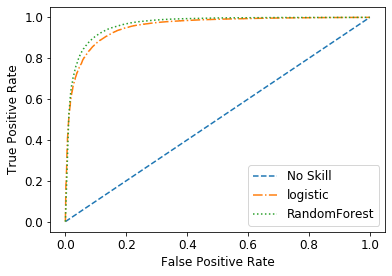

In [175]:
# plot the roc curve for the models
from matplotlib import pyplot
pyplot.plot(nomodel_fpr, nomodel_tpr, linestyle ='--', label ='No Skill')
pyplot.plot(logistic_fpr, logistic_tpr, linestyle ='-.', label ='logistic')
pyplot.plot(RandomForest_fpr, RandomForest_tpr, linestyle =':', label ='RandomForest')


#add label and ledgend
pyplot.legend()
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.show()

RandomForest has better AUC then logistic model